# Evaluate

This notebook evaluates the quality of the online alignments in a given experiment directory.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
import pandas as pd
import pickle
import re
import import_ipynb
import system_utils

## Calculate Alignment Errors

First we calculate the alignment errors of a given system on all evaluated measures.

In [3]:
def parseAnnotationFile(annotfile):
    '''
    Parses a beat annotation file.
    
    Inputs
    annotfile: filepath of the beat annotation file
    
    Returns a dictionary whose key is the measure number and whose value is the corresponding timestamp.
    '''
    df = pd.read_csv(annotfile, sep=',')
    timestamps = np.array(df['start'])
    measure_nums = np.array(df['measure'])
    d = {}
    for (t, m) in zip(timestamps, measure_nums):
        d[m] = t
    return d

In [4]:
def getEvalMeasureSet(scenarioInfo):
    '''
    Gets the list of measure indices at which to evaluate.
    
    Inputs
    scenarioInfo: the scenario.info file for the scenario of interest
    
    Returns a sorted list of measure numbers.
    '''
    d = system_utils.get_scenario_info(scenarioInfo)
    o_basename = os.path.splitext(os.path.basename(d['o']))[0] # e.g. rach2_mov1_O1
    mov_id = '_'.join(o_basename.split('_')[0:2]) # e.g. rach2_mov1
    measureSet = system_utils.get_eval_measure_set(mov_id)
    return measureSet

In [5]:
def getGroundTruthTimestamps(annotfile1, annotfile2, scenarioInfo):
    '''
    Parses two beat annotation files and returns a list of the corresponding ground truth timestamps.
    
    Inputs
    annotfile1: the first beat annotation file
    annotfile2: the second beat annotation file
    scenarioInfo: path to the scenario.info file
    
    Outputs
    eval_pts: an Nx2 array of specifying the ground truth timestamps for N measures
    overlap_measures: an array containing the list of evaluated measures, sorted in increasing order
    '''
    
    # parse annotation files
    gt1 = parseAnnotationFile(annotfile1)
    gt2 = parseAnnotationFile(annotfile2)
   
    # measures to evaluate
    allEvalMeasures = getEvalMeasureSet(scenarioInfo)
    eval_measures = sorted(set(gt1).intersection(set(gt2)).intersection(allEvalMeasures))

    # construct (t1, t2) ground truth timestamps
    eval_pts = []
    for m in eval_measures:
        eval_pts.append((gt1[m], gt2[m]))
    
    return np.array(eval_pts), np.array(eval_measures)

In [6]:
def calcAlignErrors_single(hypfile, annotfile1, annotfile2, scenarioInfo):
    '''
    Calculates the alignment errors for a single hypothesis file.
    
    Inputs
    hypfile: a .npy file containing the estimated alignment
    annotfile1: the beat annotation file for the piano recording
    annotfile2: the beat annotation file for the orchestra recording
    scenarioInfo: path to the scenario.info file
    
    Outputs
    err: the alignment errors in the estimated alignment
    measNums: the measure numbers that are evaluated
    '''
    gt, measNums = getGroundTruthTimestamps(annotfile1, annotfile2, scenarioInfo) # ground truth
    hypalign = np.load(hypfile) # piano-orchestra predicted alignment in sec
    pred = np.interp(gt[:,0], hypalign[0,:], hypalign[1,:])
    err = pred - gt[:,1]
    return err, measNums

In [7]:
def getScenarioIds(scenarios_dir):
    '''
    Gets a list of scenario ids in a given scenarios/ directory.
    
    Inputs
    scenarios_dir: directory containing scenarios information
    
    Returns a list of scenario ids, sorted in increasing order.
    '''
    summary_file = f'{scenarios_dir}/scenarios.summary'
    d = system_utils.get_scenario_info(summary_file)
    return list(d.keys())

In [8]:
def calcAlignErrors_batch(exp_dir, scenarios_dir, out_dir):
    '''
    Calculates the alignment errors for all scenarios in an experiment directory.
    
    Inputs
    exp_dir: the experiment directory to evaluate
    scenarios_dir: the directory containing the scenarios information
    out_dir: the directory to save outputs and figures to
    '''
    # evaluate all scenarios
    d = {}
    for scenario_id in getScenarioIds(scenarios_dir):
        hypFile = f'{exp_dir}/{scenario_id}/hyp.npy'
        pianoAnnot = f'{scenarios_dir}/{scenario_id}/p.beats'
        orchAnnot = f'{scenarios_dir}/{scenario_id}/o.beats'
        scenarioInfo = f'{scenarios_dir}/{scenario_id}/scenario.info'
        errs, measNums = calcAlignErrors_single(hypFile, pianoAnnot, orchAnnot, scenarioInfo)
        d[scenario_id] = (errs, measNums) # key: scenario_id, value: (errors, measureNums)
        
    # save
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    outfile = f'{out_dir}/errs.pkl'
    pickle.dump(d, open(outfile, 'wb'))

In [9]:
exp_dir = 'experiments/ISA_CHROMA' # change
scenarios_dir = 'scenarios'
eval_dir = 'eval/' + os.path.basename(exp_dir)
calcAlignErrors_batch(exp_dir, scenarios_dir, eval_dir)

## Plot Error vs Tolerance

We can visualize the results by plotting the error rate across a range of error tolerances.

In [10]:
def plotErrorVsTolerance(eval_dirs, maxTol, savefile = None):
    '''
    Plots the error rate across a range of error tolerances.
    
    Inputs
    eval_dir: the eval directories to plot
    maxTol: maximum error tolerance to consider (in milliseconds)
    savefile: if specified, will save the figure to the given filepath
    '''
    
    errRates_list = []
    for eval_dir in eval_dirs:
    
        # load
        with open(f'{eval_dir}/errs.pkl', 'rb') as f:
            d = pickle.load(f)

        # flattened list
        errs = []
        for scenario_id in d:
            errs = np.append(errs, d[scenario_id][0])

        # calculate error rates
        errRates = np.zeros(maxTol+1)
        tols = np.arange(maxTol+1)
        for i in tols:
            errRates[i] = np.mean(np.abs(errs) > i/1000)
        errRates_list.append(errRates)
            
        # plot
        plt.plot(tols, errRates * 100.0)
        
    plt.ylabel('Error Rate (%)')
    plt.xlabel('Error Tolerance (ms)')
    plt.legend([os.path.basename(eval_dir) for eval_dir in eval_dirs])
    plt.grid(linestyle='--')
    if savefile:
        plt.savefig(savefile)

    return errRates_list, tols

Plot the error rate vs error tolerance curve for one system of interest:

52.38482384823848

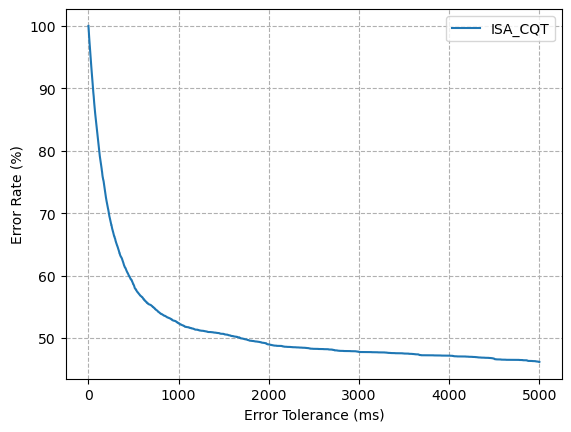

In [11]:
maxTol = 5000 # in milliseconds
eval_dir = 'eval/ISA_CQT'
errRates_list, tols = plotErrorVsTolerance([eval_dir], maxTol, savefile=False)
errRates_list[0][1000]*100.0

Overlay multiple error curves for comparison:

[5.487804878048781,
 10.05420054200542,
 19.97289972899729,
 5.555555555555555,
 11.27371273712737,
 6.720867208672086]

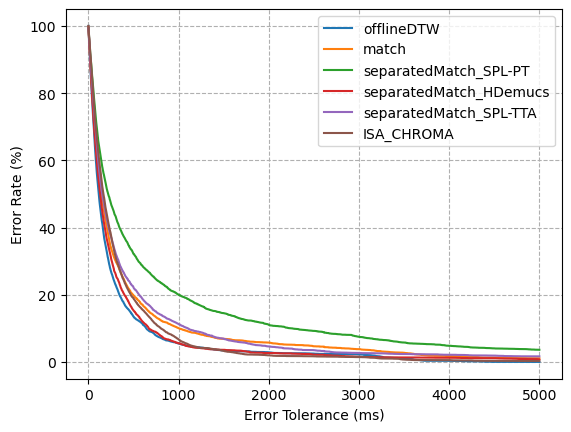

In [12]:
systems_to_compare = ['offlineDTW', 'match', 'separatedMatch_SPL-PT', 'separatedMatch_HDemucs', 'separatedMatch_SPL-TTA', 'ISA_CHROMA']
eval_dirs = [f'eval/{s}' for s in systems_to_compare]
errRates_list, tols = plotErrorVsTolerance(eval_dirs, maxTol, savefile=False)
[errRates_list[i][1000]*100.0 for i in range(len(eval_dirs))]

## Separate error curves by condition

Visualize the same error curve for a single system, but separated by different conditions.  For example, one can visualize the performance across:
- TSM factor
- full mix recording
- concerto
- composer
- chunk within a movement

In [13]:
def plotErrorVsTolerance_separated(eval_dir, mapping, maxTol, savefile = None):
    '''
    Plots error rate across a range of error tolerances.  Data is separated into categories
    specified in the given dictionary, and each category is plotted as a separate curve.
    
    Inputs
    eval_dir: the eval directory to process
    mapping: a dictionary whose key is the scenario id and whose value is the category name.
      Any scenario ids that are not in the dictionary will be excluded from the plot.
    maxTol: maximum error tolerance to consider (in milliseconds)
    savefile: if specified, will save the figure to the given filepath
    '''
    
    # initialize
    categories = list(sorted(set(mapping.values())))
    errors_by_category = {}
    for c in categories:
        errors_by_category[c] = [] # flattened list of alignment errors by category
    
    # load
    with open(f'{eval_dir}/errs.pkl', 'rb') as f:
        d = pickle.load(f)  # key: scenario_id, value: (errors, measureNums)

    # aggregate data by category
    for scenario_id in d:
        if scenario_id in mapping:
            category = mapping[scenario_id]
            errors_by_category[category] = np.append(errors_by_category[category], d[scenario_id][0])

    # calculate error rates by category
    errRates_list = {}
    numPts = {}
    for c in categories:
        errRates = np.zeros(maxTol+1)
        tols = np.arange(maxTol+1)
        for i in tols:
            errRates[i] = np.mean(np.abs(errors_by_category[c]) > i/1000)
        errRates_list[c] = errRates
        numPts[c] = len(errors_by_category[c]) # for debugging
        plt.plot(tols, errRates * 100.0)
        
    plt.ylabel('Error Rate (%)')
    plt.xlabel('Error Tolerance (ms)')
    plt.legend(categories)
    plt.grid(linestyle='--')
    if savefile:
        plt.savefig(savefile)

    return errRates_list, tols, numPts

In [14]:
def mapByTSMFactor():
    '''
    Constructs a mapping separated by TSM factor.
    '''
    d = system_utils.get_scenario_info(SCENARIOS_SUMMARY)
    mapping = {}
    for scenario_id in d:
        mapping[scenario_id] = d[scenario_id]['p'].split('/')[-2] # e.g. 'tsm0.80'
    return mapping

In [15]:
def mapByFullMix():
    '''
    Constructs a mapping separated by full mix recording.
    '''
    d = system_utils.get_scenario_info(SCENARIOS_SUMMARY)
    mapping = {}
    for scenario_id in d:
        mapping[scenario_id] = os.path.splitext(os.path.basename(d[scenario_id]['po']))[0] # e.g. 'rach2_mov1_PO1'
    return mapping

In [16]:
def mapByComposer():
    '''
    Constructs a mapping separated by composer.
    '''
    d = system_utils.get_scenario_info(SCENARIOS_SUMMARY)
    mapping = {}
    for scenario_id in d:
        po_id = os.path.splitext(os.path.basename(d[scenario_id]['po']))[0] # e.g. 'rach2_mov1_PO1'
        concerto_id = po_id.split('_')[0] # e.g. 'rach2'
        composer = re.search(r'([a-z]+)\d+', concerto_id).group(1)
        mapping[scenario_id] = composer

    return mapping

In [17]:
def mapByChunk(mov_id):
    '''
    Constructs a mapping separated by chunk within a specified concerto movement.
    
    Inputs
    mov_id: id specifying the concerto movement to analyze, e.g. 'rach2_mov1'
    '''
    # construct mapping with tuple categories
    d = system_utils.get_scenario_info(SCENARIOS_SUMMARY)
    mapping = {}
    for scenario_id in d:
        if mov_id in d[scenario_id]['po']: # only keep scenario ids for the concerto movement of interest
            mapping[scenario_id] = (d[scenario_id]['measStart'], d[scenario_id]['measEnd'])
        
    # map tuples to string (e.g. 'chunk1', 'chunk2'
    tup2str = {}
    for i, tup in enumerate(sorted(set(mapping.values()))):
        tup2str[tup] = f'Chunk{i+1}'

    # construct mapping with string categories
    renamed = {}
    for scenario_id in mapping:
        renamed[scenario_id] = tup2str[mapping[scenario_id]]
        
    return renamed

In [18]:
eval_dir = 'eval/ISA_CQT'
maxTol = 1000 # in milliseconds
SCENARIOS_SUMMARY = 'scenarios/scenarios.summary'

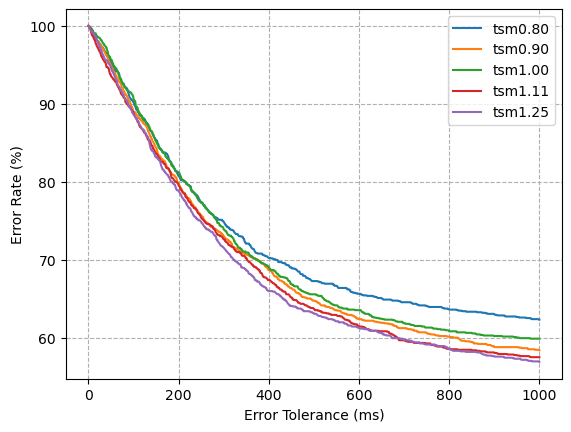

In [19]:
errRates_list, tols, numPts = plotErrorVsTolerance_separated(eval_dir, mapByTSMFactor(), maxTol)

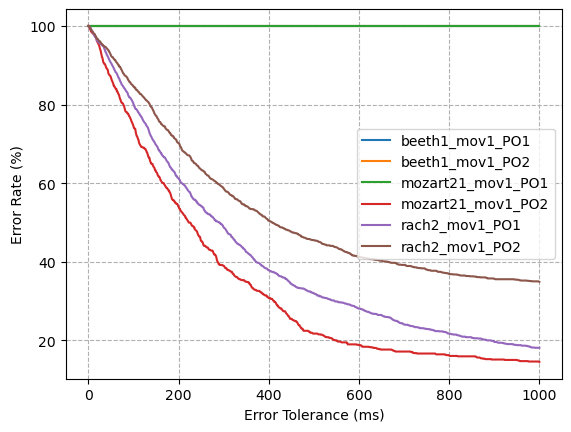

In [20]:
errRates_list, tols, numPts = plotErrorVsTolerance_separated(eval_dir, mapByFullMix(), maxTol)

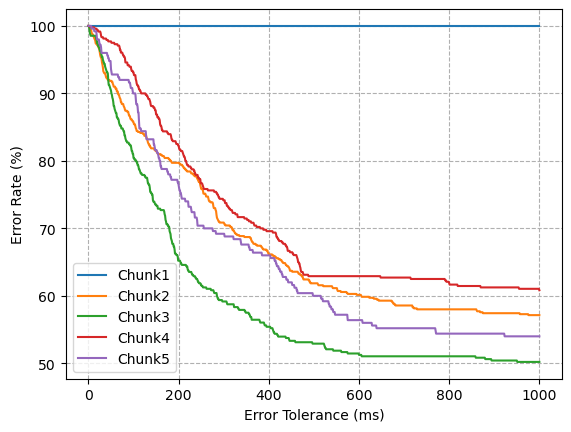

In [24]:
errRates_list, tols, numPts = plotErrorVsTolerance_separated(eval_dir, mapByChunk('mozart21_mov1'), maxTol)

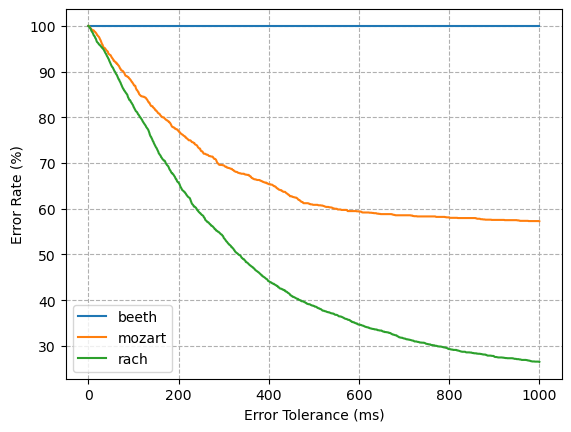

In [22]:
errRates_list, tols, numPts = plotErrorVsTolerance_separated(eval_dir, mapByComposer(), maxTol)